In [23]:
import os
import cv2
import numpy as np
import glob
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.metrics import classification_report, confusion_matrix


In [4]:
# Define the root directory
root_dir = r'C:\Users\21650\Downloads\UCSD_Anomaly_Dataset'  # Replace with your path

# Initialize dictionaries to store file paths
train_files = {'UCSDped1': [], 'UCSDped2': []}
test_files = {'UCSDped1': [], 'UCSDped2': []}

# Collect file paths for training and testing
for dataset in ['UCSDped1', 'UCSDped2']:
    train_dir = os.path.join(root_dir, dataset, 'Train')
    test_dir = os.path.join(root_dir, dataset, 'Test')

    # Collect training files
    train_paths = glob.glob(os.path.join(train_dir, '**', '*.[Tt][Ii][Ff]'), recursive=True)
    train_files[dataset].extend(train_paths)

    # Collect testing files
    test_paths = glob.glob(os.path.join(test_dir, '**', '*.[Tt][Ii][Ff]'), recursive=True)
    test_files[dataset].extend(test_paths)

In [5]:
# Function to preprocess images
def preprocess_images(image_paths, target_size=(128, 128)):
    images = []
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)  # Load image
        if img is not None:
            img = cv2.resize(img, target_size)  # Resize image
            img = img.astype('float32') / 255.0  # Normalize pixels
            images.append(img)
    return np.array(images)

In [6]:
# Preprocess training and test images for both datasets
train_images_ped1 = preprocess_images(train_files['UCSDped1'])
train_images_ped2 = preprocess_images(train_files['UCSDped2'])
test_images_ped1 = preprocess_images(test_files['UCSDped1'])
test_images_ped2 = preprocess_images(test_files['UCSDped2'])

# Combine images from both datasets
train_images = np.concatenate([train_images_ped1, train_images_ped2], axis=0)
test_images = np.concatenate([test_images_ped1, test_images_ped2], axis=0)

# Add channel dimension (for grayscale images)
train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]


In [7]:
# Define the Convolutional Autoencoder
def build_autoencoder(input_shape=(128, 128, 1)):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

In [8]:
# Instantiate and summarize the autoencoder model
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,801 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the autoencoder on normal frames only
epochs = 50
batch_size = 32

history = autoencoder.fit(
    train_images, train_images,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.1
)


Epoch 1/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 140s 526ms/step - loss: 0.0139 - val_loss: 0.0020
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 140s 530ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 140s 532ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 152s 578ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 144s 546ms/step - loss: 0.0015 - val_loss: 9.8194e-04
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 139s 529ms/step - loss: 0.0014 - val_loss: 9.2685e-04
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 144s 549ms/step - loss: 0.0013 - val_loss: 9.0825e-04
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 137s 519ms/step - loss: 0.0012 - val_loss: 8.2828e-04
Epoch 9/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 134s 510ms/step - loss: 0.0011 - val_loss: 8.3278e-04
Epoch 10/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 168s 639ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 11/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 189s 717ms/step - loss: 0.0011 - val_l

In [20]:
autoencoder.save_weights('model_weights.weights.h5')
print("Model weights saved.")
autoencoder.save('trained_model.h5')
print("Full model saved.")



Model weights saved.
Full model saved.


In [16]:
# Set a threshold for anomaly detection based on training reconstruction error
reconstructed_train = autoencoder.predict(train_images)
mse_train = np.mean(np.square(train_images - reconstructed_train), axis=(1, 2, 3))
threshold = np.mean(mse_train) + 2 * np.std(mse_train)
print(f"Anomaly detection threshold: {threshold}")

293/293 ━━━━━━━━━━━━━━━━━━━━ 41s 139ms/step
Anomaly detection threshold: 0.0011677246075123549


In [11]:
# Detect anomalies in the test set
reconstructed_test = autoencoder.predict(test_images)
mse_test = np.mean(np.square(test_images - reconstructed_test), axis=(1, 2, 3))
anomalies = mse_test > threshold


288/288 ━━━━━━━━━━━━━━━━━━━━ 45s 156ms/step


In [12]:
# Display the number of anomalies detected
print(f"Number of anomalous frames detected: {np.sum(anomalies)}")

Number of anomalous frames detected: 1272


In [14]:
def plot_anomaly_detection(test_images, reconstructed_images, mse, threshold, num_images=5):
    plt.figure(figsize=(15, 6))
    anomalous_indices = np.where(mse > threshold)[0]
    for i, idx in enumerate(anomalous_indices[:num_images]):
        # Original
        plt.subplot(2, num_images, i + 1)
        plt.imshow(test_images[idx].squeeze(), cmap='gray')
        plt.title("Original (Anomalous)")
        plt.axis('off')

        # Reconstruction
        plt.subplot(2, num_images, i + num_images + 1)
        plt.imshow(reconstructed_images[idx].squeeze(), cmap='gray')
        plt.title(f"Reconstructed\nError: {mse[idx]:.4f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

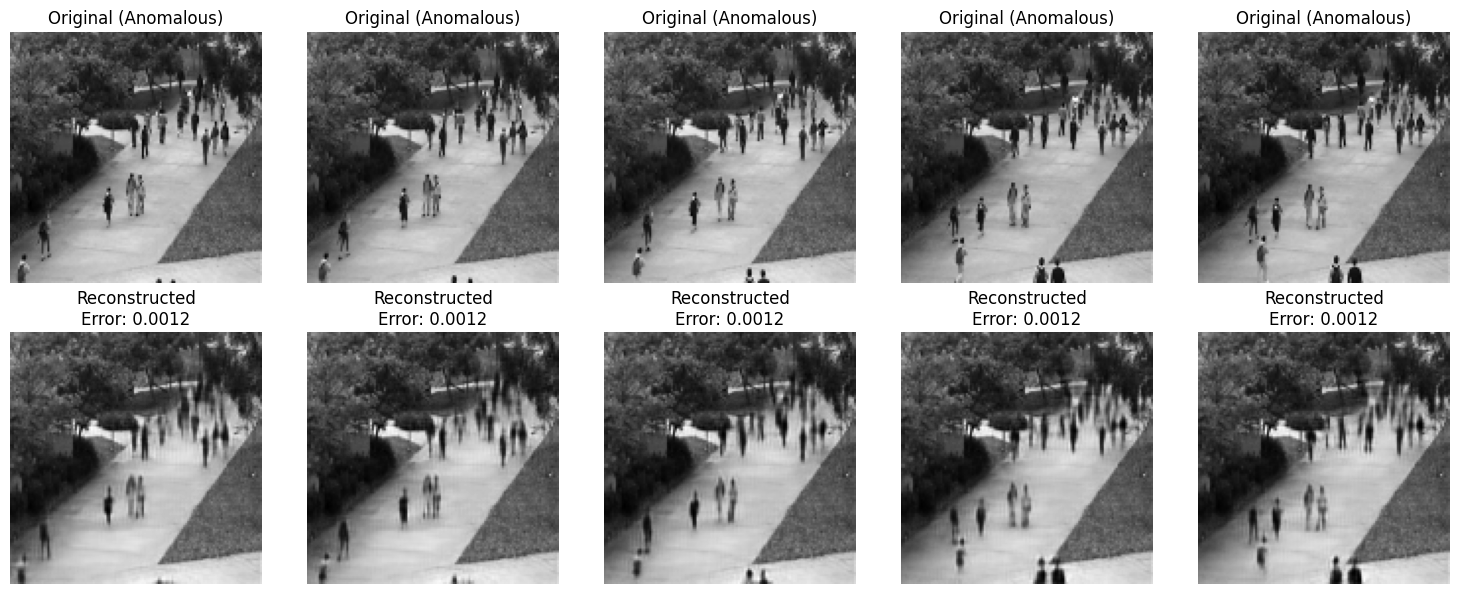

In [15]:
# Plot a few anomalies
plot_anomaly_detection(test_images, reconstructed_test, mse_test, threshold)

In [28]:
# Ground truth from TestVideoFile
test_video_file = [
    list(range(60, 153)), list(range(50, 176)), list(range(91, 201)), list(range(31, 169)),
    list(range(5, 91)) + list(range(140, 201)), list(range(1, 101)) + list(range(110, 201)),
    list(range(1, 176)), list(range(1, 95)), list(range(1, 49)), list(range(1, 141)),
    list(range(70, 166)), list(range(130, 201)), list(range(1, 157)), list(range(1, 201)),
    list(range(138, 201)), list(range(123, 201)), list(range(1, 48)), list(range(54, 121)),
    list(range(64, 139)), list(range(45, 176)), list(range(31, 201)), list(range(16, 108)),
    list(range(8, 166)), list(range(50, 172)), list(range(40, 136)), list(range(77, 145)),
    list(range(10, 123)), list(range(105, 201)), list(range(1, 16)) + list(range(45, 114)),
    list(range(175, 201)), list(range(1, 181)), list(range(1, 53)) + list(range(65, 116)),
    list(range(5, 166)), list(range(1, 122)), list(range(86, 201)), list(range(15, 109))
]


In [30]:
# Determine boundaries for the datasets
num_ped1_frames = len(test_images_ped1)
num_ped2_frames = len(test_images_ped2)

# Separate mse_test and anomalies into respective datasets
mse_test_ped1 = mse_test[:num_ped1_frames]
mse_test_ped2 = mse_test[num_ped1_frames:]

anomalies_ped1 = anomalies[:num_ped1_frames]
anomalies_ped2 = anomalies[num_ped1_frames:]

# Map anomalies to frame numbers
anomalous_frames_ped1 = np.where(anomalies_ped1)[0]
anomalous_frames_ped2 = np.where(anomalies_ped2)[0]

print(f"Number of anomalous frames detected in UCSDped1: {len(anomalous_frames_ped1)}")
print(f"Number of anomalous frames detected in UCSDped2: {len(anomalous_frames_ped2)}")

# Evaluate against ground truth
def evaluate_anomalies(anomalous_frames, ground_truth):
    true_positives = len(set(anomalous_frames) & set(ground_truth))
    false_positives = len(set(anomalous_frames) - set(ground_truth))
    false_negatives = len(set(ground_truth) - set(anomalous_frames))

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1_score

# Evaluate for each dataset
gt_ped1 = test_video_file[0]  # Replace with correct index for UCSDped1 ground truth
gt_ped2 = test_video_file[1]  # Replace with correct index for UCSDped2 ground truth

precision_ped1, recall_ped1, f1_ped1 = evaluate_anomalies(anomalous_frames_ped1, gt_ped1)
precision_ped2, recall_ped2, f1_ped2 = evaluate_anomalies(anomalous_frames_ped2, gt_ped2)

print(f"UCSDped1 - Precision: {precision_ped1:.2f}, Recall: {recall_ped1:.2f}, F1 Score: {f1_ped1:.2f}")
print(f"UCSDped2 - Precision: {precision_ped2:.2f}, Recall: {recall_ped2:.2f}, F1 Score: {f1_ped2:.2f}")


Number of anomalous frames detected in UCSDped1: 920
Number of anomalous frames detected in UCSDped2: 352
UCSDped1 - Precision: 0.04, Recall: 0.43, F1 Score: 0.08
UCSDped2 - Precision: 0.07, Recall: 0.20, F1 Score: 0.10
